<a href="https://colab.research.google.com/github/neilhazra/November2PDSWorkshop/blob/main/PDSWorkshop2AnswerKey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop 2: Predicting Wild Fire Cause with Data Science
## Authors: 
* Neil Hazra (nhazra@princeton.edu)
* Jana Sebaali (jsebaali@princeton.edu)

Sections:
Brief Introduction to Wildfire Data?

1. Brief Introduction to Wildfire Data
2. Supervised vs Unsupervised Learning
3. What is KMeans Clustering?
4. Using KMeans to analyze wild fires
5. What is K-Nearest-Neighbors?
6. How can we use K-Nearest-Neighbors to predict Fire Cause?

#Getting started
We first get the data into our Google Colab environment from a Github repository.

In [6]:
!git clone https://github.com/neilhazra/November2PDSWorkshop

fatal: destination path 'November2PDSWorkshop' already exists and is not an empty directory.


First lets import our go-to data handling libraries: numpy and pandas. 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Next, lets read in the data to a dataframe and diplay the first 20 rows to get a sense of the data. Here are the (non-straightforward) relevant column definitions: 
* FIRE_YEAR = Calendar year in which the fire was discovered or confirmed to exist.
* DISCOVERY_DATE = Date on which the fire was discovered or confirmed to exist.
* DISCOVERY_DOY = Day of year on which the fire was discovered or confirmed to exist.
* DISCOVERY_TIME = Time of day that the fire was discovered or confirmed to exist.
* STATCAUSECODE = Code for the (statistical) cause of the fire.
* **STATCAUSEDESCR = Description of the (statistical) cause of the fire.**
* CONT_DATE = Date on which the fire was declared contained or otherwise controlled (mm/dd/yyyy where mm=month, dd=day, and yyyy=year).
* CONT_DOY = Day of year on which the fire was declared contained or otherwise controlled.
* CONT_TIME = Time of day that the fire was declared contained or otherwise controlled (hhmm where hh=hour, mm=minutes).
* FIRE_SIZE = Estimate of acres within the final perimeter of the fire.
* FIRESIZECLASS = Code for fire size based on the number of acres within the final fire perimeter expenditures (A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres).


In [5]:
df = pd.read_csv('/content/November2PDSWorkshop/Fires_new.csv', error_bad_lines=False)
df.head(20)

,Unnamed: 0,OBJECTID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,1001645,1001646,NaN,1992,2448638.5,17,NaN,2,Equipment Use,NaN,NaN,NaN,0.10,A,36.245000,-81.195000,14,MISSING/NOT SPECIFIED,NC,NaN,NaN,NaN
1,937017,937018,NaN,1997,2450556.5,108,NaN,5,Debris Burning,NaN,NaN,NaN,1.10,B,35.620000,-89.205000,14,MISSING/NOT SPECIFIED,TN,NaN,NaN,NaN
2,148530,148531,1620,2002,2452538.5,264,1328.0,4,Campfire,2452538.5,264.0,1500.0,0.10,A,43.966389,-121.426944,5,USFS,OR,NaN,NaN,NaN
3,585412,585413,NaN,2004,2453037.5,33,NaN,3,Smoking,NaN,NaN,NaN,0.10,A,34.091950,-79.857220,14,MISSING/NOT SPECIFIED,SC,Florence,41.0,Florence
4,647506,647507,NaN,2008,2454610.5,145,NaN,9,Miscellaneous,NaN,NaN,NaN,0.50,B,33.762970,-97.021260,14,MISSING/NOT SPECIFIED,TX,Cooke,97.0,Cooke
5,960193,960194,NaN,1999,2451273.5,95,NaN,5,Debris Burning,NaN,NaN,NaN,170.00,D,25.400000,-80.440000,14,MISSING/NOT SPECIFIED,FL,Miami Dade,86.0,Miami-Dade
6,319865,319866,LMU LGT 14,2004,2453183.5,179,1918.0,1,Lightning,2453184.5,180.0,1400.0,0.20,A,40.904900,-120.871100,1,BLM,CA,Lassen,35.0,Lassen
7,420657,420658,NaN,2003,2452731.5,92,NaN,6,Railroad,NaN,NaN,NaN,0.17,A,31.149087,-82.292424,14,MISSING/NOT SPECIFIED,GA,Ware,299.0,Ware
8,383025,383026,NaN,2006,2453941.5,206,NaN,9,Miscellaneous,NaN,NaN,NaN,2.00,B,35.621960,-92.455760,14,MISSING/NOT SPECIFIED,AR,Van Buren,141.0,Van Buren
9,935752,935753,NaN,2002,2452602.5,328,NaN,7,Arson,NaN,NaN,NaN,5.00,B,35.055000,-88.388300,14,MISSING/NOT SPECIFIED,TN,NaN,NaN,NaN


#Supervised vs Unsupervised Machine Learning!
Last month we covered regression which is a form of supervised learning on continuous data. Supervised learning algorithms use pairings in the form $(X,Y)$ to learn the relationship between $X$ and $Y$. We sometimes refer to the $Y$ variables are called labels and data of the form $(X,Y)$ is known as labeled data. On the other hand, unsupervised learning algorithms look for natural patterns and structure in the data and work with unlabeled data, where the Y values are not present. 

As an easy example, lets say you are identifying leaves. In supervised machine learning you would find a collection of leaves for which you already know their identification (cherry, birch, maple, etc). You would pass this labeled data into your machine learning algorithm and your model would predict the type of leaf.

In unsupervised machine learning you would not have access to the identificatoin (or labels) and the algorithm would simply try to group similar leaves together, not having any information on what a maple or birch leave looks like.   




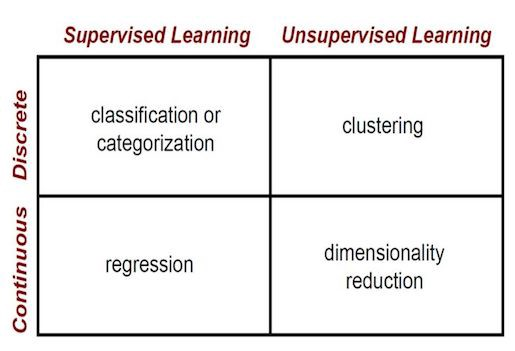

**Today, we will look at two algorithms for discrete data: KMeans and K-Nearest-Neighbors.**

#What is KMeans

K Means is an **unsupervised** **clustering** algorithm. Consider the following plot of points:
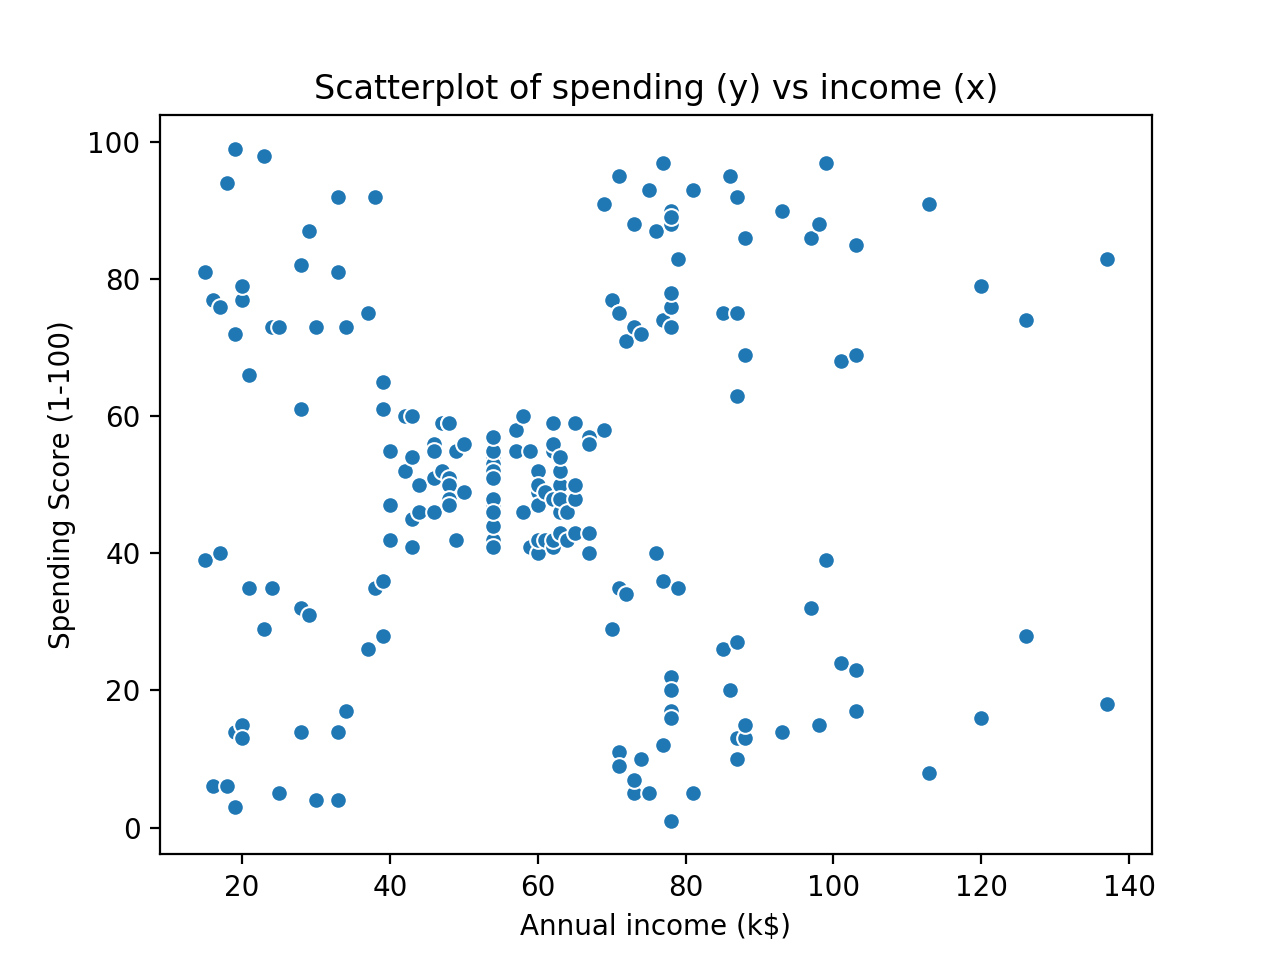

It is very easy for us to visually identify five groups of points or clusters. The goal of the KMeans algorithm is to solve this clustering problem for multidimentional vectors which are impossible for humans to cluster visually. 

##Mathematical Problem Statement
To be precise let $x[n]$ be the collection of all $n$ vectors to be clustered. So as a simple example if we are clustering geospatial location our vectors would look like: 

$x_{1} = (\text{10, 90, 0})$

$x_{2} = (\text{5, 95, 5})$

$x_{3} = (\text{0, 100, 10})$.



Now lets define $\mu_{k}$ to be mean (or center) of the kth cluster. 

$\mu_{1} = (\text{8, 92, 0.5})$

$\mu_{2} = (\text{0, 100, 10})$



Next define a collection of variables (called indicator variables) as follows:
$
r_{nk}=
\begin{cases}
1&if\ x_{n\ }is \ closest \ to \ \mu_{k} \\
0 & \ otherwise\
\end{cases}
$

For instance,

$r_{1,1} = 1, r_{1,2} = 0$

$r_{3,1} = 0, r_{3,2} = 1$


It should be clear that this collection of variables is completely determined by the location of the cluster means $\mu_{k}$. In other words, after we choose our k cluster centers (or means) we have a unique clustering. 
Let's get more familiar with this notation: What is $\sum_{k=1}^{K}r_{nk}$ for any n?

Lastly, in order to convert our clustering problem into an optimization problem, we can define an objective function (also known as a distortion measure) that quantifies how good our clustering is. Then finding a good clustering is equivalent to optimizing the following function with respect to $\mu_{k}$:


$J=\sum_{k=1}^{K}\sum_{n=1}^{N}r_{nk}\left|\left|x_{n}-\mu_{k}\right|\right|^2$

If the indicator variable notation is confusing, this is an equivalent way of looking at it:

$J=\sum_{k=1}^{K}\sum_{n\in k}\left|\left|x_{n}-\mu_{k}\right|\right|^2$


What is this objective function measuring? 
* It's measuring the total squared distance from every data point to the center of its cluster
* In other words, we are minimizing the total variation within clusters. 


http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf

##Algorithm Demonstration

KMeans is an iterative algorithm that can be thought of in two high level steps. First we start with a random guess of cluster centers. Now we repeat the following two steps:

1.   Find the optimal  assignment given the location of the cluster centers
2.   Find the optimal cluster centers given the clustering assignment

When our cluster centers or clustering assignment does not change during an iteration we are finished with the algorithm. Let's walk through this algorithm with the following image. 


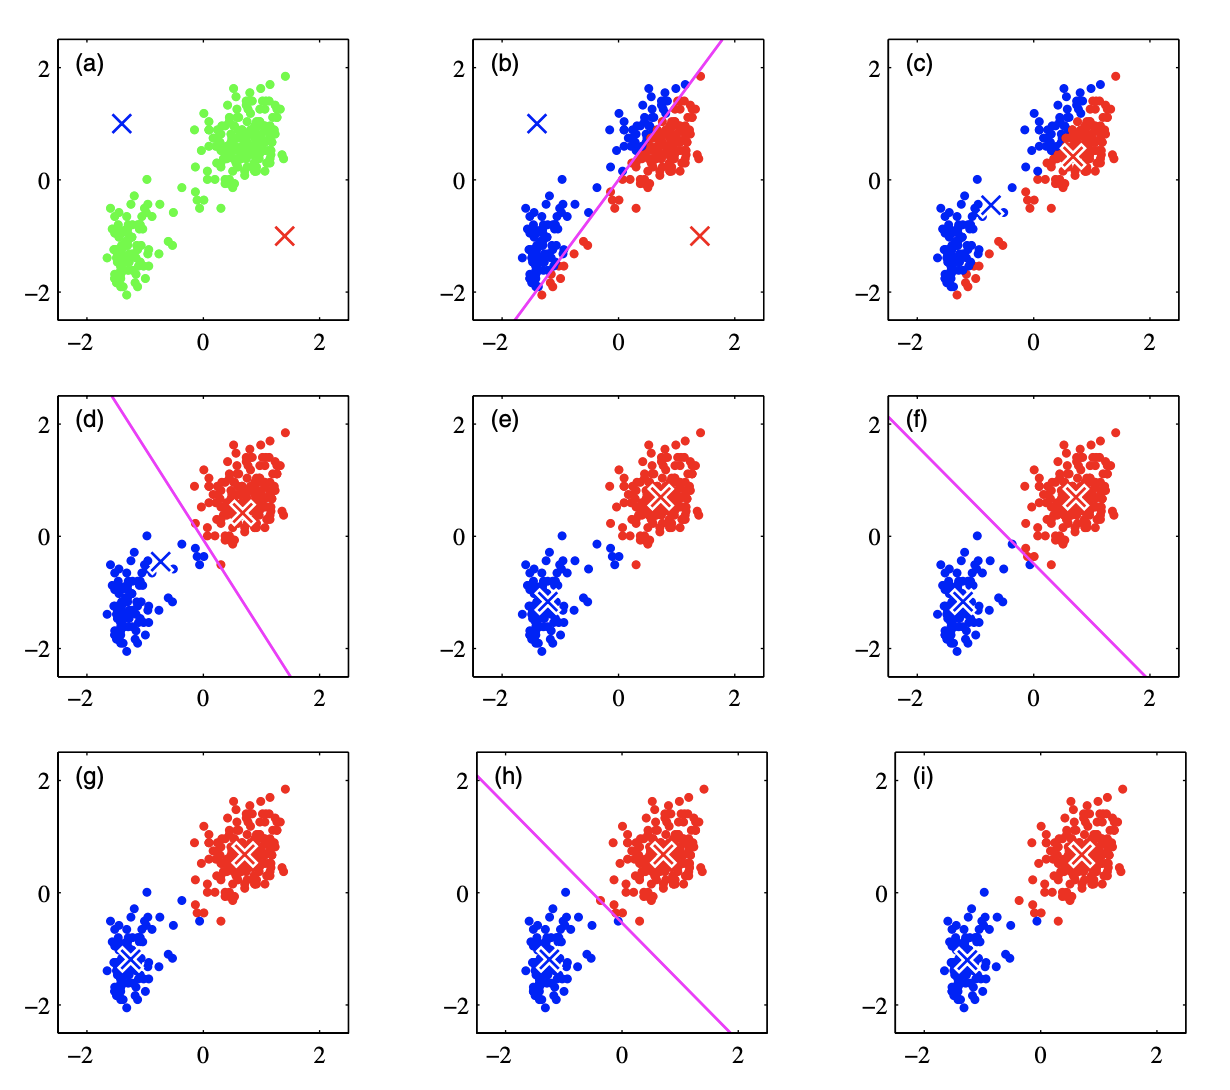

##Using KMeans to analyze wild fires

In [5]:
#import our libraries 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

A key step in practical data science is cleaning up the data. Datasets that you find in the real world are messy and have missing data. Since this dataset was pulled from a data science website most of the data preprocessing has been done, but we should still remove incomplete data samples. 

In [6]:
# drop rows where we have NaN in DOY/Time
df = df.dropna(subset=['DISCOVERY_DOY', 'CONT_DOY', 'DISCOVERY_TIME','CONT_TIME'])

Let's create a new dataframe with the features we are interested in.
Note that all the features are continuous and ordered. Notice that when we wrote down the mathematical kmeans statements we used a distance metric between samples and the mean of a cluster. This only makes sense if the variables are ordered.  

In [7]:
X_total = df[["LATITUDE", "LONGITUDE"]]  

In [8]:
Y = np.ravel(df[["STATE"]])
unique_values = df['STATE'].unique()

Next we need to scale our data so that all coordinates in our vectors are weighted equally. To understand why this is important, pretend that instead of measuring lattitude in degrees we measured it in arcseconds (a very small unit for angle). Our objective function would no longer care about difference in longitude since an equivalent distance in lattitude would result in an increase in our objective function 3600^2 times as big.   

In [9]:
scaler = MinMaxScaler() 
X_scaled = pd.DataFrame(scaler.fit_transform(X_total), columns=X_total.columns)

In [11]:
#note that we are not passing in Y, this is the hallmark of an unsupervised learning algorithm 
kmeans = KMeans(n_clusters = len(unique_values), n_init=5 ,random_state=42).fit(X_scaled)
kmeans_prediction = kmeans.predict(X_scaled)

##Visualizing the Clusters

Let's visualize the clusters in a intuitive away. Here I plot lattitude and longitude on the x and y coordinates. Note how the clusters are homogenous and resembles the United States.

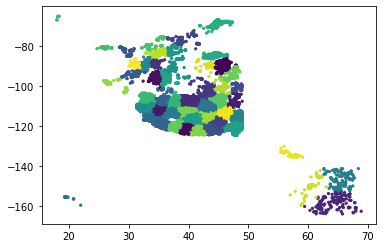

In [12]:
plt.scatter(X_total.to_numpy()[:,0], X_total.to_numpy()[:,1], c=kmeans_prediction, s=5, cmap='viridis')

Lets look at the distribution of fire causes among the clusters and see if the kmeans algorithm has found similiarties in the groups that are potentially reflective of the fire cause. 

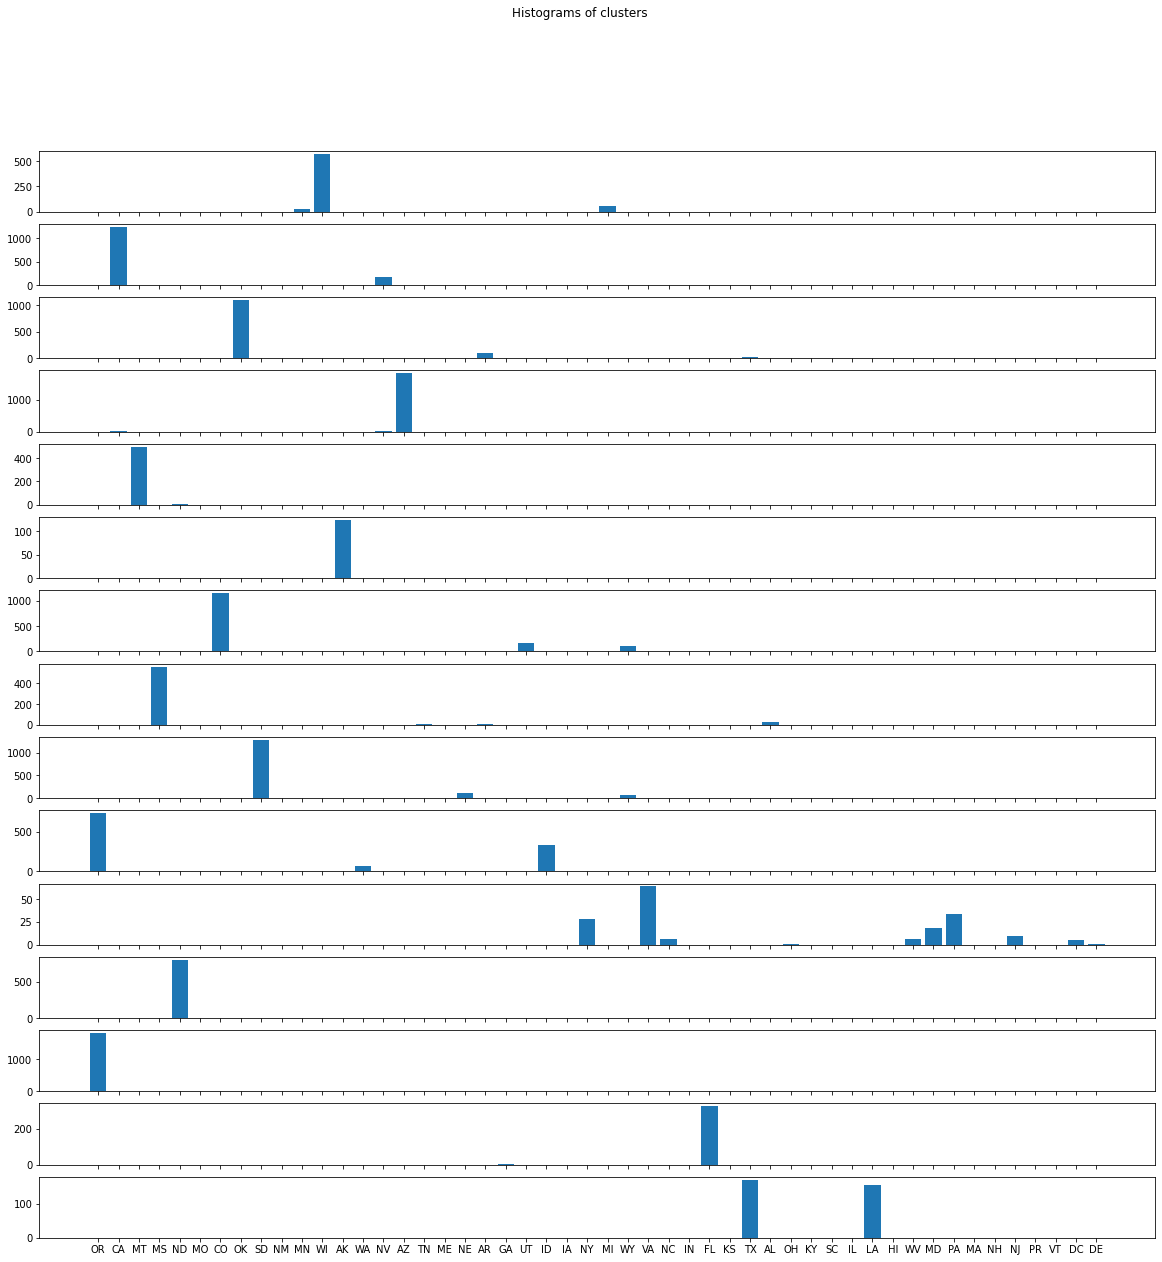

In [13]:
fig, axs = plt.subplots(15, sharex= True)
fig.set_figheight(20)
fig.set_figwidth(20)
fig.suptitle('Histograms of clusters')
for i in range(15):
  indices = np.where(kmeans_prediction == i)[0]
  cluster_points = Y[indices]
  counts = [np.count_nonzero(cluster_points == cause) for cause in unique_values]
  axs[i].bar(unique_values, counts)
for ax in fig.get_axes():
    ax.label_outer()

Now let's see if we can extract some information and structure out of the fires dataset. Unspervised learning is unable to predict anything but it helps reveal structure and patterns which may be useful for further data analysis. 

In [15]:
X_total = df[["DISCOVERY_DOY", "LATITUDE", "LONGITUDE", "FIRE_SIZE"]]
Y = np.ravel(df[["STAT_CAUSE_DESCR"]])
unique_values = df['STAT_CAUSE_DESCR'].unique()
scaler = MinMaxScaler() 
X_scaled = pd.DataFrame(scaler.fit_transform(X_total), columns=X_total.columns)
#note that we are not passing in Y, this is the hallmark of an unsupervised learning algorithm 
kmeans = KMeans(n_clusters = len(unique_values), n_init=5 ,random_state=42).fit(X_scaled)
kmeans_prediction = kmeans.predict(X_scaled)

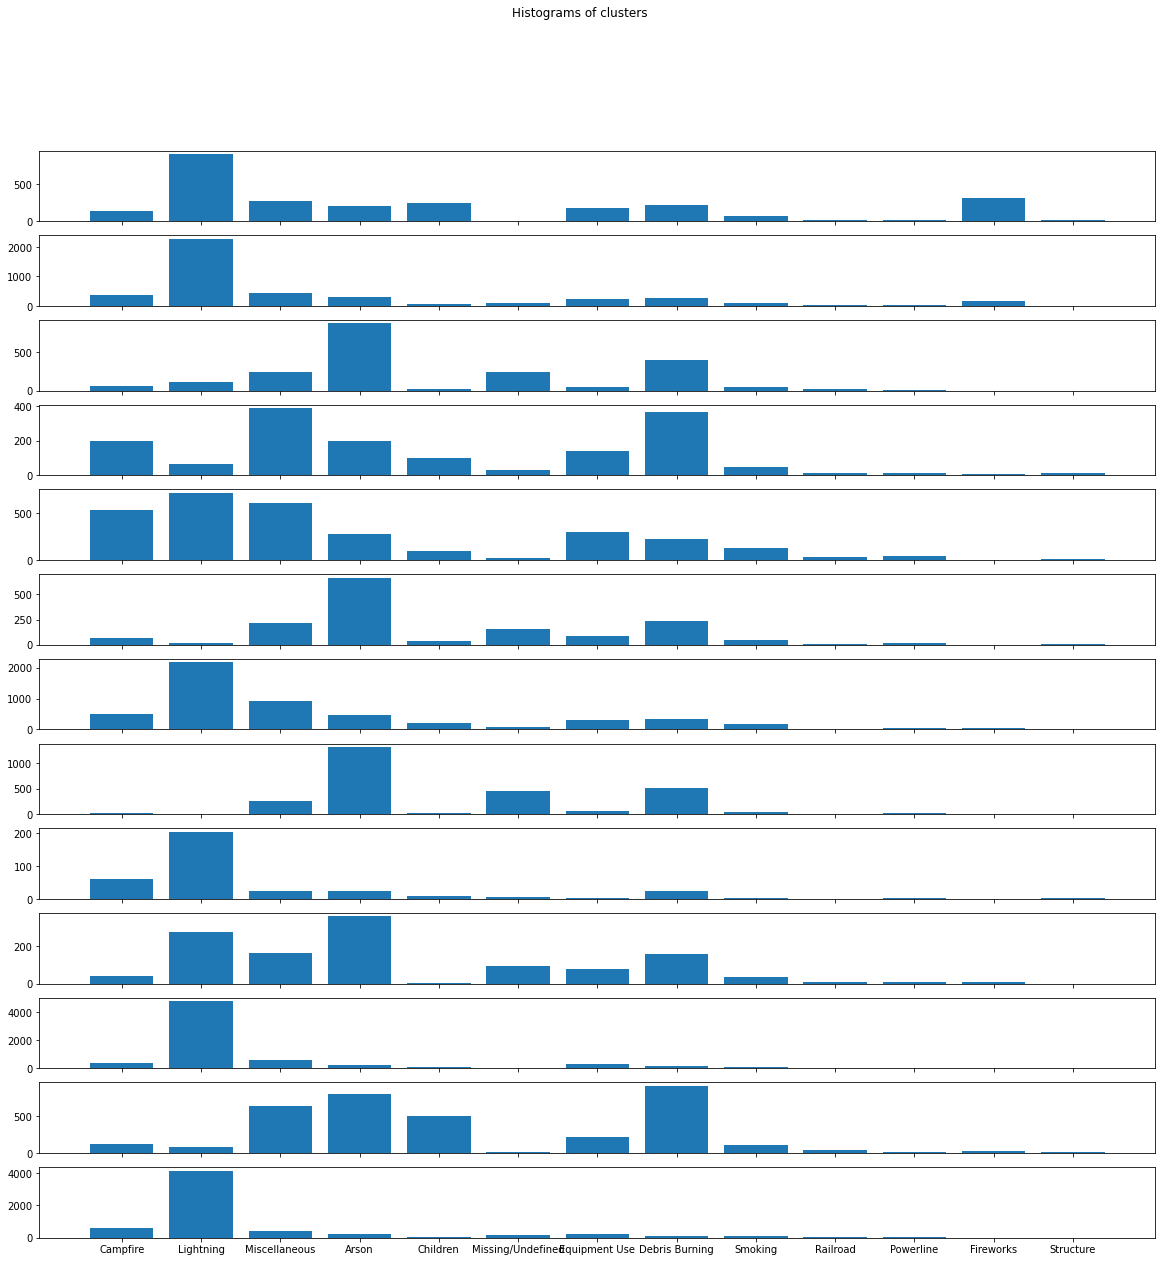

In [16]:
fig, axs = plt.subplots(len(unique_values), sharex= True)
fig.set_figheight(20)
fig.set_figwidth(20)
fig.suptitle('Histograms of clusters')
for i in range(len(unique_values)):
  indices = np.where(kmeans_prediction == i)[0]
  cluster_points = Y[indices]
  counts = [np.count_nonzero(cluster_points == cause) for cause in unique_values]
  axs[i].bar(unique_values, counts)
for ax in fig.get_axes():
    ax.label_outer()

# Supervised Learning: k-nearest neighbors



The k-nearest neighbors (KNN) algorithm is a **supervised**, **similarity-based** machine learning algorithm that can be used to solve **classification** problems. 

### What is similarity-based learning?

Similarity based algorithms make a prediction for a
query by finding situations that are similar to
it in the dataset. The prediction is based on what was true for the most similar situations in the dataset. Similarity is measured using euclidean distance in k-Nearest Neighbors (k-NN).

### How does k-Nearest Neighbors work?

We need to choose k to be the number of neighbors. For each instance in the data, calculate the euclidean distance between the instance and the query. Pick the first k entries that are closest to the query, get the labels of the selected k entries, and return the majority vote.


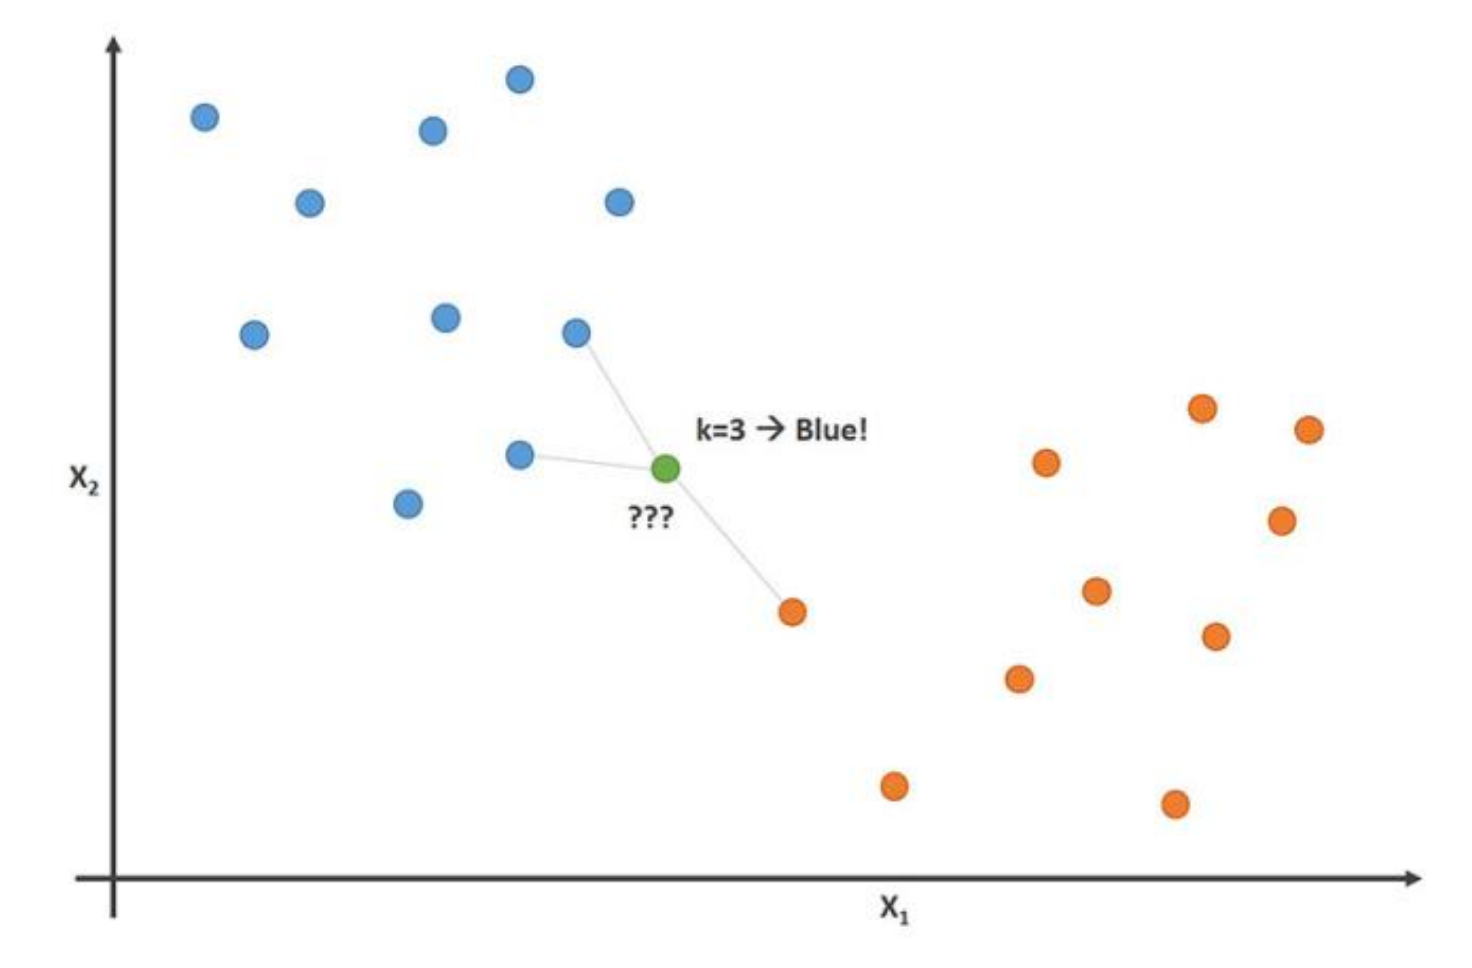

### How do you choose k?

Small values for k will overfit the data and make the decision boundaries very irregular, as shown below. The colored regions indicate all those points in input space classified as BLUE or ORANGE.

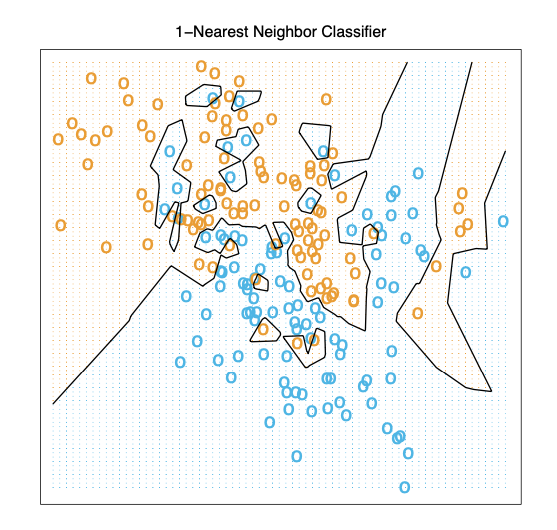

We want to choose the right value for k such that the decision boundaries are smooth, as in the figure below. We can choose k using **cross validation.**


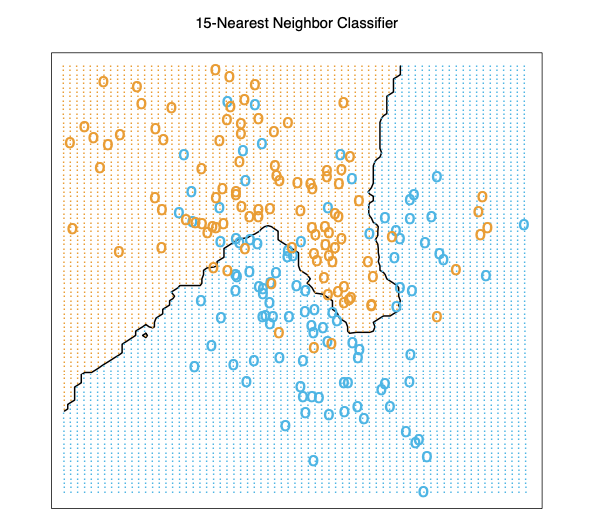

### What is k-fold cross validation?

k-fold cross-validation is when the dataset is randomly split up into ‘k’ groups. One of the groups is used as the **test set** and the rest are used as the **training set**. The model is trained on the training set and scored on the test set. Then the process is repeated until each unique group has been used as the test set, and the final score is the average of all k scores.

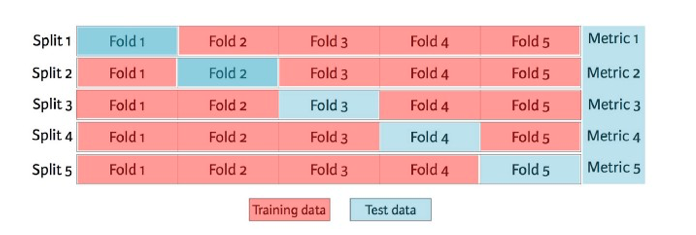

Perform cross validation on the dataset using different values of k and see which one performs best.

### Using K-Nearest Neighbor to predict the cause of the fires

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection  import cross_val_score

Features that would help predict the cause of the fire would be DISCOVERY_DOY, DISCOVERY_TIME, LATITUDE, LONGITUDE, FIRE_SIZE, and OWNER_CODE.

In [ ]:
# X_total holds the relevant features. Y_total holds the labels.
X_total = df[["DISCOVERY_DOY", "DISCOVERY_TIME", "LATITUDE", "LONGITUDE", "FIRE_SIZE", "OWNER_CODE"]]
Y_total = np.ravel(df[["STAT_CAUSE_DESCR"]])  # Returns a contiguous flattened array.


In [ ]:
# Do the necessary scaling.
scaler = MinMaxScaler() 
X_scaled = pd.DataFrame(scaler.fit_transform(X_total), columns=X_total.columns)

In [ ]:
# Cross validation
# choose k between 1 to 20
k_range = range(1, 50)
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_total, Y_total, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

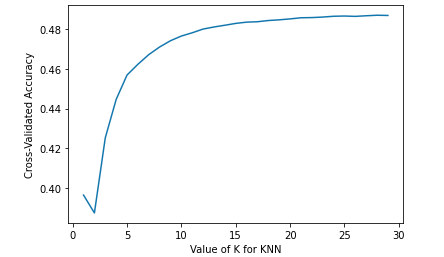

Choose the best k based on the accuracy scores. Now, let's split the dataset into a training set and test set and use a confusion matrix to visually check which causes are best predicted.

In [ ]:
# Split into training and test set 
X_train, X_test, y_train, y_test = train_test_split( 
             X_scaled, Y_total, test_size = 0.2) 

In [ ]:
# Train the model using the best k.
knn = KNeighborsClassifier(n_neighbors=15) 
knn.fit(X_train, y_train) 

In [ ]:
# Plot a confusion matrix to visually assess the performance of the model. 
disp = plot_confusion_matrix(knn, X_test, y_test,
                             display_labels= df["STAT_CAUSE_DESCR"].unique(),
                             cmap=plt.cm.Blues,                            
                             normalize='true')
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()